source: https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/content/drive/My Drive/Dataset/plantdisease-tugasakhir2/train"))

# Any results you write to the current directory are saved as output.

['Apple___Apple_scab', 'Apple___Black_rot', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot']


Using TensorFlow backend.


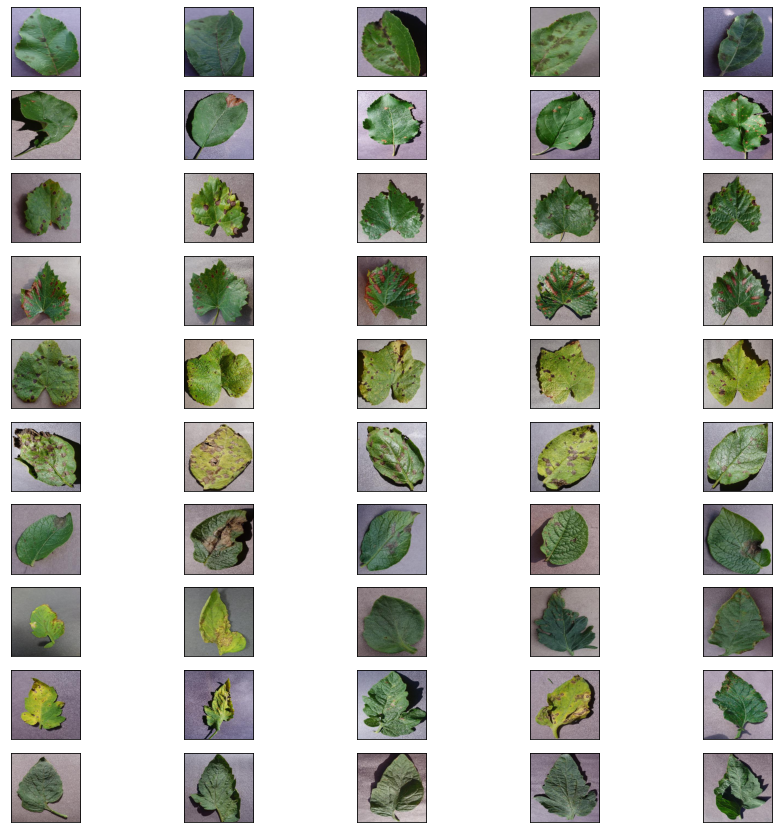

In [0]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
%matplotlib inline

files = [[path+f for f in os.listdir(path)[:5]] for path in [f'/content/drive/My Drive/Dataset/plantdisease-tugasakhir2/train/{x}/' for x in ['Apple___Apple_scab', 'Apple___Black_rot', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Potato___Early_blight', 'Potato___Late_blight', 'Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Tomato___Target_Spot']]]

fig, axs = plt.subplots(10, 5, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

for ax, img in zip(axs.flatten(), [item for sublist in files for item in sublist]):
    ax.imshow(load_img(img))

In [0]:
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
NUM_CLASSES = 10

CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'
RESNET50_WEIGHT = 'imagenet'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 20
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 50
BATCH_SIZE_VALIDATION = 10

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [0]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, BatchNormalization, Dropout, Flatten

In [0]:
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = RESNET50_WEIGHT, input_shape=(224,224,3)))

model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
94773248/94765736 [==============================] - 8s 0us/step


In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1

In [0]:
from tensorflow.python.keras import optimizers

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = adam, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)

In [0]:
# Early stopping & checkpointing the best model in ../working dir & restoring that as our model for prediction
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint

cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE)
cb_checkpointer = ModelCheckpoint(filepath = '/content/drive/My Drive/Dataset/best6.hdf5', monitor = 'val_loss', save_best_only = True, mode = 'auto')

In [0]:
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

image_size = IMAGE_RESIZE

# preprocessing_function is applied on each image but only after re-sizing & augmentation (resize => augment => pre-process)
# Each of the keras.application.resnet* preprocess_input MOSTLY mean BATCH NORMALIZATION (applied on each batch) stabilize the inputs to nonlinear activation functions
# Batch Normalization helps in faster convergence
data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.3)

# flow_From_directory generates batches of augmented data (where augmentation can be color conversion, etc)
# Both train & valid folders must have NUM_CLASSES sub-folders
train_generator = data_generator.flow_from_directory(
        '/content/drive/My Drive/Dataset/plantdisease-tugasakhir2/train',
        target_size=(image_size, image_size),
        batch_size=BATCH_SIZE_TRAINING,
        class_mode='categorical')

validation_generator = data_generator.flow_from_directory(
    '/content/drive/My Drive/Dataset/plantdisease-tugasakhir2/train',
    target_size=(image_size, image_size),
    batch_size=BATCH_SIZE_VALIDATION,
    class_mode='categorical',
    subset='validation') 

Found 5000 images belonging to 10 classes.
Found 1500 images belonging to 10 classes.


In [0]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [0]:
fit_history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = NUM_EPOCHS,
        validation_data = validation_generator, 
        callbacks=[cb_checkpointer, cb_early_stopper]
)

Epoch 1/20
10/10 [==============================] - 1047s 105s/step - loss: 0.9644 - acc: 0.7180 - val_loss: 1.2894 - val_acc: 0.4793
Epoch 2/20
10/10 [==============================] - 9s 888ms/step - loss: 0.2184 - acc: 0.9240 - val_loss: 1.1658 - val_acc: 0.5573
Epoch 3/20
10/10 [==============================] - 211s 21s/step - loss: 0.2089 - acc: 0.9280 - val_loss: 1.0770 - val_acc: 0.6220
Epoch 4/20
10/10 [==============================] - 196s 20s/step - loss: 0.1658 - acc: 0.9360 - val_loss: 0.9307 - val_acc: 0.6693
Epoch 5/20
10/10 [==============================] - 237s 24s/step - loss: 0.1365 - acc: 0.9600 - val_loss: 0.9806 - val_acc: 0.6553
Epoch 6/20
 5/10 [==============>...............] - ETA: 1:34 - loss: 0.1299 - acc: 0.9400

In [0]:
model.load_weights("/content/drive/My Drive/Dataset/best.hdf5")

In [0]:
print(fit_history.history.keys())

In [0]:
plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_history.history['acc'])  
plt.plot(fit_history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_history.history['loss'])  
plt.plot(fit_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()